In [117]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import torch
from tensorboardX import SummaryWriter
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset
import re

In [17]:
cons=ts.get_apis()
df=ts.bar(
    code='000300',
    conn=cons,
    start_date='2015-01-01',
    end_date='',
    asset='INDEX',
    retry_count=3,
    freq='5min'
)

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


In [21]:
df.head

<bound method NDFrame.head of                        code     open    close     high      low        vol  \
datetime                                                                     
2021-06-15 13:55:00  000300  5176.93  5176.54  5177.59  5176.54  258673.72   
2021-06-15 13:50:00  000300  5172.21  5177.10  5177.10  5172.21  398656.80   
2021-06-15 13:45:00  000300  5172.87  5172.55  5172.99  5170.67  426467.08   
2021-06-15 13:40:00  000300  5171.30  5172.60  5173.26  5169.04  403498.36   
2021-06-15 13:35:00  000300  5175.08  5172.25  5175.08  5172.20  439969.12   
...                     ...      ...      ...      ...      ...        ...   
2019-05-29 09:55:00  000300  3651.44  3647.74  3651.44  3646.14  296074.58   
2019-05-29 09:50:00  000300  3646.73  3651.19  3653.25  3642.04  334188.42   
2019-05-29 09:45:00  000300  3646.29  3646.80  3646.80  3637.35  430049.60   
2019-05-29 09:40:00  000300  3643.68  3646.15  3649.19  3641.80  499165.92   
2019-05-29 09:35:00  000300  3642.

In [82]:
def generate_data_by_n_days(series_list,series_num,n):
    
    '''
        function:generate a dataframe by rolling window
        args:
            series(series/list):the list we need to roll
            n(int):the size of rolling window
        return:
            df(dataframe) 
    '''
    
    df=pd.DataFrame()
    for j in range(series_num):
        for i in range(n):
            ##normalization
            df_numpy=np.array(series_list[j].tolist()[i:-(n-i)])
            df_numpy=(df_numpy-np.mean(df_numpy))/np.std(df_numpy)
            df["c%d%d"%(j,i)]=df_numpy
    df['y']=series_list[0].tolist()[n:]
    df.dropna()
    return df
raw_data=generate_data_by_n_days([df['close'],df['vol'],df['amount'],df['high'],df['low']],5,30)

In [83]:
raw_data.shape

(23861, 151)

In [84]:
class RNN(nn.Module):
    
    '''
        class:one-layer lstm and a full-connected network
        input:
            tensor(30*1)
        output:
            tensor(1*1)
    '''
    
    def __init__(self,input_size):
        super(RNN,self).__init__()
        self.rnn=nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.out=nn.Sequential(
            nn.Linear(64,1)
        )
    def forward(self,x):
        r_out,(h_n,h_c)=self.rnn(x,None)
        out=self.out(r_out)
        return out

In [112]:
def genertate_train_test_set(rowdata,trainratio=0.7):
     
    '''
        function:generate train_test set
        args:
            rowdata(dataframe): the rawdata
            trainratio(float):len(train_set)/len(test_set)
        return:
            train_set(dataframe)
            test_set(dataframe)
    '''
    
    train_len=int(trainratio*len(rowdata))
    train_set=rowdata[:train_len]
    test_set=rowdata[train_len+1:]
    return train_set,test_set

device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(device)

feature_size=150
rnn=RNN(feature_size).to(device)
optimizer=torch.optim.Adam(rnn.parameters(),lr=0.1)
train_set,test_set=genertate_train_test_set(raw_data)

                         
train_set=torch.Tensor(np.array(train_set))
test_set=torch.Tensor(np.array(test_set))

print(train_set.shape)
print(test_set.shape)
trainloader=DataLoader(train_set,batch_size=500,shuffle=False)
print(train_set)
loss_function=nn.MSELoss()

cuda:0
torch.Size([16702, 151])
torch.Size([7158, 151])
tensor([[ 1.2744e+00,  1.2755e+00,  1.2680e+00,  ...,  1.2340e+00,
          1.2545e+00,  5.1696e+03],
        [ 1.2754e+00,  1.2679e+00,  1.2681e+00,  ...,  1.2544e+00,
          1.2717e+00,  5.1972e+03],
        [ 1.2678e+00,  1.2680e+00,  1.2675e+00,  ...,  1.2716e+00,
          1.3111e+00,  5.2026e+03],
        ...,
        [-4.3538e-01, -4.3454e-01, -4.3923e-01,  ..., -4.1354e-01,
         -4.1444e-01,  4.1586e+03],
        [-4.3464e-01, -4.3933e-01, -4.4001e-01,  ..., -4.1454e-01,
         -4.1584e-01,  4.1601e+03],
        [-4.3944e-01, -4.4012e-01, -4.3781e-01,  ..., -4.1594e-01,
         -4.1159e-01,  4.1585e+03]])


In [113]:
def train(lose_function):
    
    '''
        function:train the dataset with different loss function
        args:
            loss_function:the loss_function we selected
        return:
            loss_list:the loss when we train
    '''
    
    loss_list=[]
    for step in range(5000):
        sum=0.0
        for tx in trainloader:
            ##print(tx.shape)
            features=torch.unsqueeze(tx,dim=0).to(device)
            output=rnn(features[:,:,0:150])
            loss=loss_function(torch.squeeze(output),features[:,:,150])
            loss_list.append(float(loss.data))
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
        print("step:%d,loss:%d"%(step,loss.data))
    return loss_list

In [114]:
loss_list=train(nn.MSELoss)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 500])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 202])) that is different to the input size (torch.Size([202])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step:0,loss:16921550
step:1,loss:16246984
step:2,loss:15505851
step:3,loss:14632573
step:4,loss:13309820
step:5,loss:12001706
step:6,loss:10763745
step:7,loss:9589731
step:8,loss:8601145
step:9,loss:7734202
step:10,loss:6971944
step:11,loss:6094236
step:12,loss:5384882
step:13,loss:4586951
step:14,loss:3997740
step:15,loss:4128660
step:16,loss:3407047
step:17,loss:2470749
step:18,loss:2033309
step:19,loss:1798699
step:20,loss:1428213
step:21,loss:1135517
step:22,loss:995363
step:23,loss:754614
step:24,loss:657293
step:25,loss:477805
step:26,loss:375104
step:27,loss:297824
step:28,loss:240411
step:29,loss:189446
step:30,loss:153826
step:31,loss:132852
step:32,loss:143081
step:33,loss:157538
step:34,loss:111921
step:35,loss:86088
step:36,loss:88950
step:37,loss:85198
step:38,loss:86029
step:39,loss:84426
step:40,loss:83900
step:41,loss:82208
step:42,loss:82029
step:43,loss:82292
step:44,loss:83845
step:45,loss:83669
step:46,loss:80788
step:47,loss:79798
step:48,loss:78950
step:49,loss:78

step:411,loss:39223
step:412,loss:40713
step:413,loss:39870
step:414,loss:42097
step:415,loss:39294
step:416,loss:40082
step:417,loss:39650
step:418,loss:39199
step:419,loss:41196
step:420,loss:39841
step:421,loss:40526
step:422,loss:38355
step:423,loss:39536
step:424,loss:38103
step:425,loss:40510
step:426,loss:38869
step:427,loss:42101
step:428,loss:42459
step:429,loss:39154
step:430,loss:38781
step:431,loss:37901
step:432,loss:38305
step:433,loss:37696
step:434,loss:37007
step:435,loss:37602
step:436,loss:37053
step:437,loss:41641
step:438,loss:38075
step:439,loss:37810
step:440,loss:36430
step:441,loss:35571
step:442,loss:35680
step:443,loss:37762
step:444,loss:36906
step:445,loss:36522
step:446,loss:36438
step:447,loss:36752
step:448,loss:37211
step:449,loss:37915
step:450,loss:37884
step:451,loss:37239
step:452,loss:38803
step:453,loss:36694
step:454,loss:36808
step:455,loss:36758
step:456,loss:38126
step:457,loss:36253
step:458,loss:38475
step:459,loss:40266
step:460,loss:38560


step:821,loss:30269
step:822,loss:30025
step:823,loss:30481
step:824,loss:29995
step:825,loss:29909
step:826,loss:29990
step:827,loss:30503
step:828,loss:31081
step:829,loss:30832
step:830,loss:30727
step:831,loss:30727
step:832,loss:32080
step:833,loss:30164
step:834,loss:30464
step:835,loss:30105
step:836,loss:30044
step:837,loss:30659
step:838,loss:30199
step:839,loss:30389
step:840,loss:30140
step:841,loss:30153
step:842,loss:30031
step:843,loss:29930
step:844,loss:30058
step:845,loss:32177
step:846,loss:29954
step:847,loss:32302
step:848,loss:32488
step:849,loss:32285
step:850,loss:32174
step:851,loss:31825
step:852,loss:32487
step:853,loss:32586
step:854,loss:31722
step:855,loss:31664
step:856,loss:32011
step:857,loss:31902
step:858,loss:31790
step:859,loss:32483
step:860,loss:32048
step:861,loss:31649
step:862,loss:32255
step:863,loss:32098
step:864,loss:33937
step:865,loss:32227
step:866,loss:32711
step:867,loss:31237
step:868,loss:31100
step:869,loss:30916
step:870,loss:30708


step:1220,loss:17316
step:1221,loss:17334
step:1222,loss:17183
step:1223,loss:17648
step:1224,loss:17248
step:1225,loss:16822
step:1226,loss:16758
step:1227,loss:17005
step:1228,loss:16813
step:1229,loss:16576
step:1230,loss:16692
step:1231,loss:16505
step:1232,loss:16559
step:1233,loss:16448
step:1234,loss:16380
step:1235,loss:16496
step:1236,loss:16198
step:1237,loss:16783
step:1238,loss:16559
step:1239,loss:16362
step:1240,loss:14226
step:1241,loss:14148
step:1242,loss:14395
step:1243,loss:14151
step:1244,loss:14341
step:1245,loss:14158
step:1246,loss:14337
step:1247,loss:14038
step:1248,loss:13907
step:1249,loss:14406
step:1250,loss:13990
step:1251,loss:14516
step:1252,loss:16660
step:1253,loss:13818
step:1254,loss:14726
step:1255,loss:14488
step:1256,loss:13890
step:1257,loss:13796
step:1258,loss:13868
step:1259,loss:13754
step:1260,loss:13913
step:1261,loss:13831
step:1262,loss:15335
step:1263,loss:15399
step:1264,loss:15839
step:1265,loss:15487
step:1266,loss:15281
step:1267,los

step:1611,loss:19556
step:1612,loss:19366
step:1613,loss:19404
step:1614,loss:19358
step:1615,loss:19118
step:1616,loss:18123
step:1617,loss:18298
step:1618,loss:18030
step:1619,loss:18535
step:1620,loss:18136
step:1621,loss:17942
step:1622,loss:17945
step:1623,loss:17883
step:1624,loss:17925
step:1625,loss:17814
step:1626,loss:17892
step:1627,loss:17785
step:1628,loss:17732
step:1629,loss:17878
step:1630,loss:17789
step:1631,loss:18098
step:1632,loss:17665
step:1633,loss:17864
step:1634,loss:17678
step:1635,loss:17762
step:1636,loss:17634
step:1637,loss:17708
step:1638,loss:17685
step:1639,loss:17675
step:1640,loss:17583
step:1641,loss:17514
step:1642,loss:17525
step:1643,loss:17468
step:1644,loss:17581
step:1645,loss:17385
step:1646,loss:17372
step:1647,loss:17343
step:1648,loss:17331
step:1649,loss:17303
step:1650,loss:17280
step:1651,loss:17207
step:1652,loss:20884
step:1653,loss:18654
step:1654,loss:17418
step:1655,loss:17579
step:1656,loss:17645
step:1657,loss:18124
step:1658,los

step:2002,loss:15176
step:2003,loss:14937
step:2004,loss:14943
step:2005,loss:14958
step:2006,loss:14994
step:2007,loss:15036
step:2008,loss:14964
step:2009,loss:15004
step:2010,loss:14938
step:2011,loss:14989
step:2012,loss:15012
step:2013,loss:15024
step:2014,loss:14959
step:2015,loss:15062
step:2016,loss:15037
step:2017,loss:14964
step:2018,loss:15134
step:2019,loss:14896
step:2020,loss:14976
step:2021,loss:15194
step:2022,loss:15152
step:2023,loss:15384
step:2024,loss:14743
step:2025,loss:14951
step:2026,loss:14845
step:2027,loss:15116
step:2028,loss:14946
step:2029,loss:14673
step:2030,loss:14921
step:2031,loss:14670
step:2032,loss:14670
step:2033,loss:14713
step:2034,loss:14516
step:2035,loss:14702
step:2036,loss:14570
step:2037,loss:14549
step:2038,loss:14594
step:2039,loss:14533
step:2040,loss:14582
step:2041,loss:14537
step:2042,loss:14535
step:2043,loss:14508
step:2044,loss:14541
step:2045,loss:14545
step:2046,loss:14510
step:2047,loss:14505
step:2048,loss:14464
step:2049,los

step:2393,loss:11122
step:2394,loss:11124
step:2395,loss:10998
step:2396,loss:11165
step:2397,loss:11026
step:2398,loss:10988
step:2399,loss:10922
step:2400,loss:10967
step:2401,loss:11026
step:2402,loss:10936
step:2403,loss:10985
step:2404,loss:10926
step:2405,loss:10961
step:2406,loss:10965
step:2407,loss:10946
step:2408,loss:10804
step:2409,loss:10831
step:2410,loss:10773
step:2411,loss:10806
step:2412,loss:10800
step:2413,loss:10836
step:2414,loss:10757
step:2415,loss:10747
step:2416,loss:10700
step:2417,loss:10930
step:2418,loss:10771
step:2419,loss:12933
step:2420,loss:10720
step:2421,loss:10926
step:2422,loss:10670
step:2423,loss:10923
step:2424,loss:10642
step:2425,loss:10682
step:2426,loss:10698
step:2427,loss:10674
step:2428,loss:10822
step:2429,loss:10621
step:2430,loss:10578
step:2431,loss:10614
step:2432,loss:10917
step:2433,loss:10683
step:2434,loss:10850
step:2435,loss:10563
step:2436,loss:10814
step:2437,loss:11314
step:2438,loss:10628
step:2439,loss:10534
step:2440,los

step:2787,loss:7709
step:2788,loss:7788
step:2789,loss:7662
step:2790,loss:7681
step:2791,loss:7653
step:2792,loss:7629
step:2793,loss:7615
step:2794,loss:7581
step:2795,loss:7580
step:2796,loss:7565
step:2797,loss:7541
step:2798,loss:7588
step:2799,loss:7542
step:2800,loss:7542
step:2801,loss:7514
step:2802,loss:7494
step:2803,loss:7544
step:2804,loss:7446
step:2805,loss:7434
step:2806,loss:7404
step:2807,loss:7507
step:2808,loss:7392
step:2809,loss:7619
step:2810,loss:7540
step:2811,loss:7591
step:2812,loss:7460
step:2813,loss:7404
step:2814,loss:7383
step:2815,loss:7397
step:2816,loss:7276
step:2817,loss:7349
step:2818,loss:7252
step:2819,loss:7291
step:2820,loss:7248
step:2821,loss:7230
step:2822,loss:7229
step:2823,loss:7318
step:2824,loss:7211
step:2825,loss:7350
step:2826,loss:7180
step:2827,loss:7228
step:2828,loss:7237
step:2829,loss:7187
step:2830,loss:7125
step:2831,loss:7091
step:2832,loss:7170
step:2833,loss:7109
step:2834,loss:7157
step:2835,loss:7072
step:2836,loss:7068


step:3197,loss:4216
step:3198,loss:3541
step:3199,loss:4606
step:3200,loss:3704
step:3201,loss:3636
step:3202,loss:3625
step:3203,loss:3737
step:3204,loss:3598
step:3205,loss:3666
step:3206,loss:3647
step:3207,loss:3657
step:3208,loss:3937
step:3209,loss:3551
step:3210,loss:3498
step:3211,loss:3568
step:3212,loss:3669
step:3213,loss:3574
step:3214,loss:3574
step:3215,loss:3799
step:3216,loss:3585
step:3217,loss:3455
step:3218,loss:3488
step:3219,loss:3606
step:3220,loss:3459
step:3221,loss:3528
step:3222,loss:3513
step:3223,loss:3669
step:3224,loss:3660
step:3225,loss:3504
step:3226,loss:3790
step:3227,loss:3948
step:3228,loss:3675
step:3229,loss:3707
step:3230,loss:3998
step:3231,loss:3896
step:3232,loss:3786
step:3233,loss:3858
step:3234,loss:3506
step:3235,loss:3477
step:3236,loss:3475
step:3237,loss:3487
step:3238,loss:3459
step:3239,loss:3438
step:3240,loss:3470
step:3241,loss:3429
step:3242,loss:3543
step:3243,loss:3399
step:3244,loss:3422
step:3245,loss:3380
step:3246,loss:3361


step:3607,loss:2260
step:3608,loss:2471
step:3609,loss:2479
step:3610,loss:2391
step:3611,loss:2347
step:3612,loss:2422
step:3613,loss:2367
step:3614,loss:2278
step:3615,loss:2196
step:3616,loss:2335
step:3617,loss:2347
step:3618,loss:2337
step:3619,loss:2339
step:3620,loss:2430
step:3621,loss:2754
step:3622,loss:2226
step:3623,loss:2391
step:3624,loss:2562
step:3625,loss:2681
step:3626,loss:2275
step:3627,loss:2477
step:3628,loss:2251
step:3629,loss:2332
step:3630,loss:2333
step:3631,loss:2000
step:3632,loss:2010
step:3633,loss:2237
step:3634,loss:2569
step:3635,loss:2250
step:3636,loss:2028
step:3637,loss:2024
step:3638,loss:1971
step:3639,loss:1914
step:3640,loss:1988
step:3641,loss:1913
step:3642,loss:1958
step:3643,loss:1937
step:3644,loss:1895
step:3645,loss:1918
step:3646,loss:1944
step:3647,loss:1945
step:3648,loss:1931
step:3649,loss:1922
step:3650,loss:1982
step:3651,loss:1931
step:3652,loss:1887
step:3653,loss:1910
step:3654,loss:1917
step:3655,loss:1895
step:3656,loss:1876


step:4017,loss:3155
step:4018,loss:3009
step:4019,loss:2596
step:4020,loss:2603
step:4021,loss:2496
step:4022,loss:2722
step:4023,loss:2489
step:4024,loss:2663
step:4025,loss:2539
step:4026,loss:2561
step:4027,loss:2524
step:4028,loss:2611
step:4029,loss:2606
step:4030,loss:2758
step:4031,loss:2631
step:4032,loss:2616
step:4033,loss:2598
step:4034,loss:2619
step:4035,loss:2558
step:4036,loss:2703
step:4037,loss:2643
step:4038,loss:2896
step:4039,loss:3284
step:4040,loss:2534
step:4041,loss:2557
step:4042,loss:2664
step:4043,loss:2746
step:4044,loss:3042
step:4045,loss:2651
step:4046,loss:2615
step:4047,loss:2639
step:4048,loss:2692
step:4049,loss:2501
step:4050,loss:3682
step:4051,loss:2771
step:4052,loss:2668
step:4053,loss:2618
step:4054,loss:2681
step:4055,loss:2531
step:4056,loss:2868
step:4057,loss:2528
step:4058,loss:2702
step:4059,loss:2561
step:4060,loss:2588
step:4061,loss:2509
step:4062,loss:2657
step:4063,loss:2536
step:4064,loss:2830
step:4065,loss:2488
step:4066,loss:2564


step:4427,loss:2307
step:4428,loss:1792
step:4429,loss:2173
step:4430,loss:1870
step:4431,loss:1950
step:4432,loss:1822
step:4433,loss:1972
step:4434,loss:1827
step:4435,loss:2125
step:4436,loss:1802
step:4437,loss:1830
step:4438,loss:1906
step:4439,loss:1773
step:4440,loss:1764
step:4441,loss:1846
step:4442,loss:1821
step:4443,loss:1785
step:4444,loss:1943
step:4445,loss:1827
step:4446,loss:1830
step:4447,loss:1843
step:4448,loss:1805
step:4449,loss:1769
step:4450,loss:1731
step:4451,loss:1745
step:4452,loss:1843
step:4453,loss:1927
step:4454,loss:1771
step:4455,loss:1874
step:4456,loss:1887
step:4457,loss:1738
step:4458,loss:1740
step:4459,loss:1800
step:4460,loss:1766
step:4461,loss:1867
step:4462,loss:1819
step:4463,loss:1889
step:4464,loss:1771
step:4465,loss:1902
step:4466,loss:1788
step:4467,loss:1802
step:4468,loss:1821
step:4469,loss:1713
step:4470,loss:1730
step:4471,loss:1810
step:4472,loss:1935
step:4473,loss:1759
step:4474,loss:2142
step:4475,loss:1748
step:4476,loss:1818


step:4837,loss:4120
step:4838,loss:4331
step:4839,loss:4174
step:4840,loss:4276
step:4841,loss:3994
step:4842,loss:4135
step:4843,loss:3919
step:4844,loss:4066
step:4845,loss:4079
step:4846,loss:4118
step:4847,loss:4203
step:4848,loss:4372
step:4849,loss:4657
step:4850,loss:4679
step:4851,loss:4686
step:4852,loss:4828
step:4853,loss:4494
step:4854,loss:4292
step:4855,loss:4475
step:4856,loss:4255
step:4857,loss:4375
step:4858,loss:4142
step:4859,loss:4177
step:4860,loss:4073
step:4861,loss:4294
step:4862,loss:3983
step:4863,loss:4220
step:4864,loss:4051
step:4865,loss:4467
step:4866,loss:4063
step:4867,loss:4106
step:4868,loss:4126
step:4869,loss:4719
step:4870,loss:4432
step:4871,loss:4297
step:4872,loss:4106
step:4873,loss:4137
step:4874,loss:4178
step:4875,loss:4221
step:4876,loss:4324
step:4877,loss:4048
step:4878,loss:4153
step:4879,loss:4170
step:4880,loss:4150
step:4881,loss:3989
step:4882,loss:4128
step:4883,loss:3903
step:4884,loss:3945
step:4885,loss:3924
step:4886,loss:4054


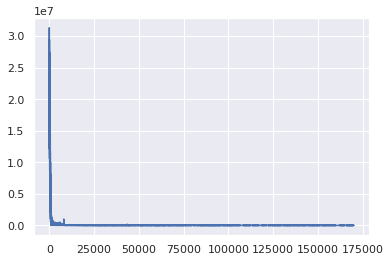

In [116]:
plt.plot(loss_list)

In [138]:
iteration_list=[]
for i in result:
    temp=re.findall(r"\d+\.?\d*",i)
    iteration_list.append(temp)
iteration_list=sum(iteration_list,[])

In [142]:
iteration_list=list(map(int,iteration_list))

In [143]:
iteration_list

[16921550,
 16246984,
 15505851,
 14632573,
 13309820,
 12001706,
 10763745,
 9589731,
 8601145,
 7734202,
 6971944,
 6094236,
 5384882,
 4586951,
 3997740,
 4128660,
 3407047,
 2470749,
 2033309,
 1798699,
 1428213,
 1135517,
 995363,
 754614,
 657293,
 477805,
 375104,
 297824,
 240411,
 189446,
 153826,
 132852,
 143081,
 157538,
 111921,
 86088,
 88950,
 85198,
 86029,
 84426,
 83900,
 82208,
 82029,
 82292,
 83845,
 83669,
 80788,
 79798,
 78950,
 78382,
 78388,
 77788,
 81350,
 92415,
 90011,
 85698,
 83563,
 82305,
 81991,
 80658,
 79381,
 78593,
 81123,
 98924,
 91842,
 90045,
 76595,
 75567,
 78184,
 76847,
 75324,
 75262,
 75228,
 74278,
 74089,
 74119,
 74291,
 73983,
 72716,
 70397,
 69710,
 69759,
 70032,
 70190,
 70182,
 70066,
 69866,
 68545,
 68675,
 71881,
 71082,
 69812,
 68662,
 75000,
 78272,
 73085,
 73257,
 70354,
 69948,
 75075,
 72487,
 70724,
 69911,
 70710,
 69584,
 66869,
 66706,
 66056,
 64745,
 64777,
 64197,
 64924,
 65180,
 66857,
 68087,
 74902,
 65312,


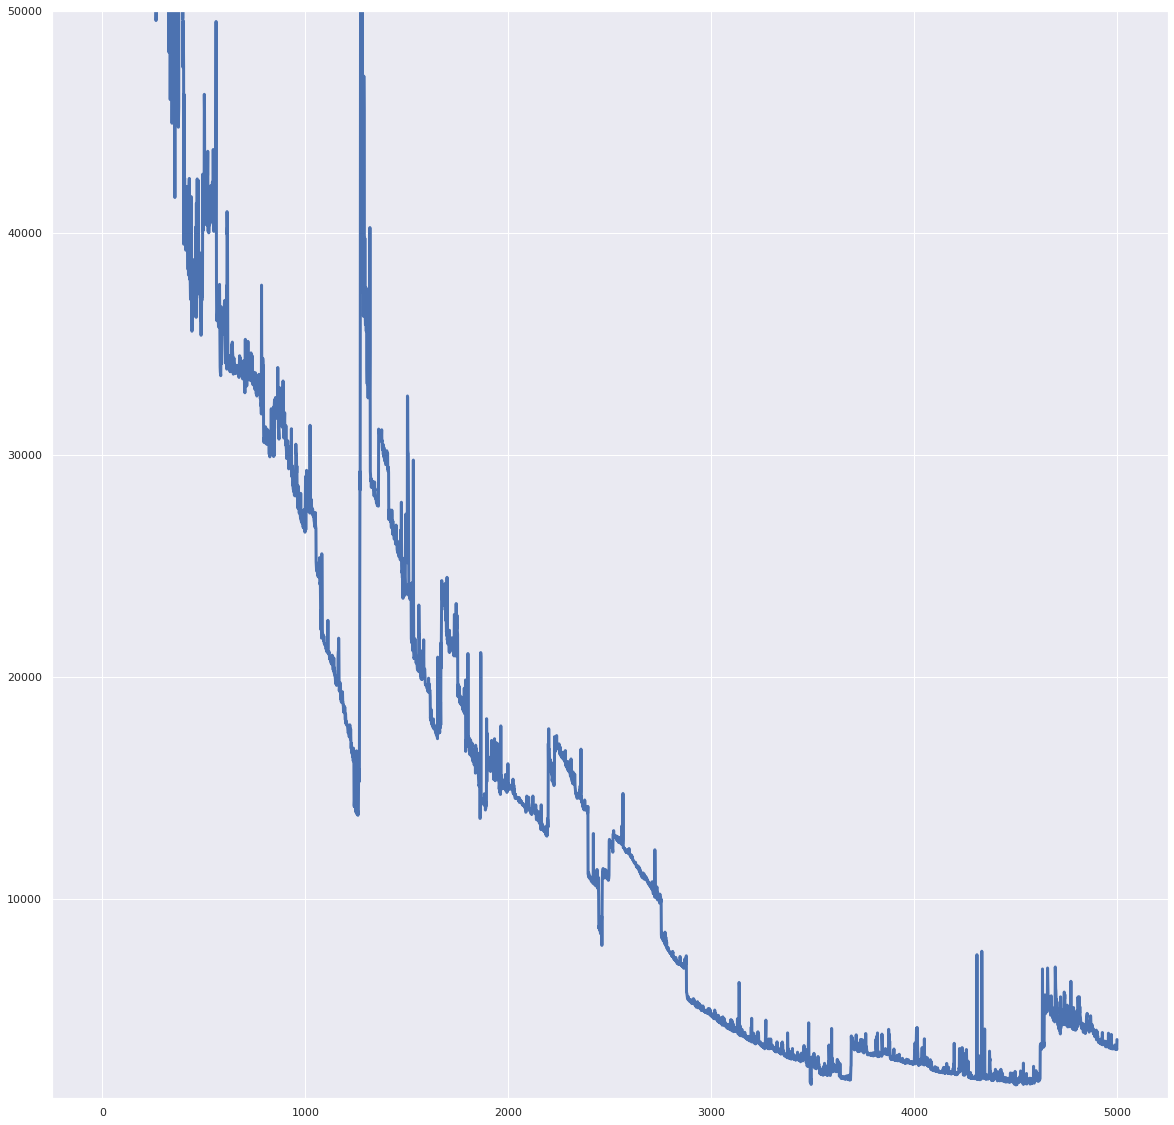

In [156]:
plt.figure(figsize=(20,20))
plt.ylim(1000,50000)
plt.plot(iteration_list,linewidth= 3 )

In [158]:
torch.save(rnn,'\basic_model.pkl')

/root/miniconda3/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
